<h1> Splitting text into paragraphs </h1>

## TOC:
* [Import libraries](#Import-libraries)
* [Load the text](#Load-the-text)
* [Load Embedding model](#Load-Embedding-model)
* [Unify sentences length](#Unify-sentences-length) 
* [Embed sentences](#Embed-sentences) 
* [Create cosine similarity matrix](#Create-cosine-similarity-matrix)
* [Find splitting points](#Find-splitting-points) 
* [Split the text in paragraphs](#Split-the-text-in-paragraphs) 


 

<h2>Import libraries</b>

In [4]:
# First let import the most necessary libs
import pandas as pd
import numpy as np
# Library to import pre-trained model for sentence embeddings
from sentence_transformers import SentenceTransformer
# Calculate similarities between sentences
from sklearn.metrics.pairwise import cosine_similarity
# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt
# package for finding local minimas
from scipy.signal import argrelextrema
import math

/home/poloniki/.pyenv/versions/3.8.12/envs/quint/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2>Load the text</h2>

In [5]:
# First lets load the transcript
with open('../quint/frontend/transcripts/podcast_transcript.txt') as f:
    doc = f.readlines()
    f.close()
# Transcript is one line, so we select it and change question mark for dots so that we split it correctly.
doc = doc[0].replace("?", ".")
sentences = doc.split('. ')
print('Loaded Text String')

Loaded Text String


<h2>Load Embedding model</h2>

In [6]:
# Loading a model - don't try it at home, it might take some time - it is 420 mb
model = SentenceTransformer('all-mpnet-base-v2')

<h2>Unify sentences length</h2>

In [7]:
# Get the length of each sentence
sentece_length = [len(each) for each in sentences]
# Determine longest outlier
long = np.mean(sentece_length) + np.std(sentece_length) *2
# Determine shortest outlier
short = np.mean(sentece_length) - np.std(sentece_length) *2
# Shorten long sentences
text = ''
for each in sentences:
    if len(each) > long:
        # let's replace all the commas with dots
        comma_splitted = each.replace(',', '.')
    else:
        text+= f'{each}. '
sentences = text.split('. ')
# Now let's concatenate short ones
text = ''
for each in sentences:
    if len(each) < short:
        text+= f'{each} '
    else:
        text+= f'{each}. '

<h2>Embed sentences</h2>

In [32]:
# Split text into sentences
sentences = text.split('. ')
# Embed sentences
embeddings = model.encode(sentences)
print(embeddings.shape)

(2663, 768)


<h2>Create cosine similarity matrix</h2>

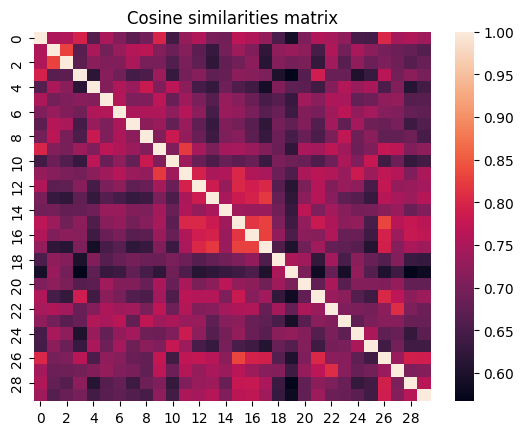

In [26]:
# Create similarities matrix
similarities = cosine_similarity(embeddings)
# Lets plot the result we got
sns.heatmap(similarities).set_title('Cosine similarities matrix');

<h2>Find splitting points</h2>

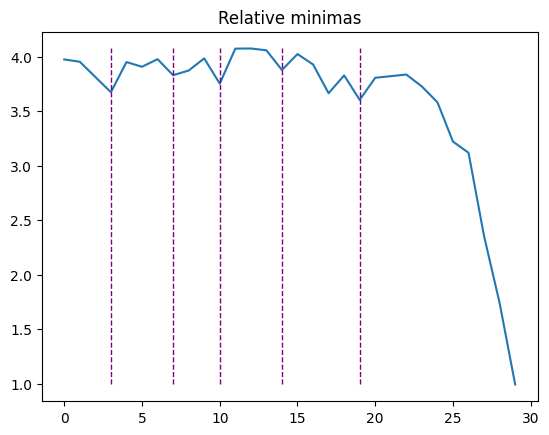

In [27]:
def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))
    
def activate_similarities(similarities:np.array, p_size=10)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum 
        Returns:
            list: list of weighted sums
        """
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid) 
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

# Let's apply our function. For long sentences i reccomend to use 10 or more sentences
activated_similarities = activate_similarities(similarities, p_size=10)

# Let's create empty fig for our plor
fig, ax = plt.subplots()
### 6. Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
minmimas = argrelextrema(activated_similarities, np.less, order=2) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.
# plot the flow of our text with activated similarities
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas');
# Now lets plot vertical lines in order to see where we created the split
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

<h3> Zoom in to see the results </h3>

(0.0, 100.0)

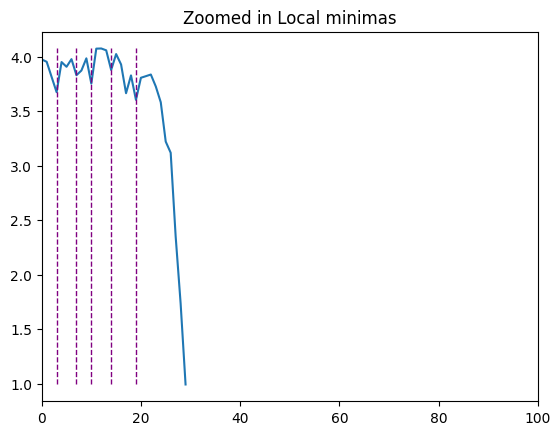

In [28]:
fig, ax = plt.subplots()
# for all local minimals
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Zoomed in Local minimas');
# Now lets plot vertical line in order to understand if we have done what we wanted
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')
ax.set_xlim([0,100])

<h2>Split the text in paragraphs</h2>

In [29]:
# Create empty string
split_points = [each for each in minmimas[0]]
text = ''
for num,each in enumerate(sentences):
    if num in split_points:
        text+=f'\n\n {each}. '
    else:
        text+=f'{each}. '

In [30]:
print(text)

In the year 1625, an Italian nobleman named Pietro de la Valet went on a tour of the Middle East. De la Valle was a prolific traveler. He journeyed around Asia, North Africa and even India. 

 He married an Assyrian Christian princess in Damascus and now the two of them traveled together, journeying by horseback and camel, accompanied by local guides. At this time, travel in this region couldn't have been more dangerous. The Ottoman and Persian empires were at war, fighting over who would rule in Baghdad. And meanwhile, local bandits took advantage of the chaos to prey on travelers. 

 In those days, lions even roamed in these hills. Due to these various dangers, dela Valets guides were constantly on edge. It was June 18, 1625 when they spotted a distant group of tribesmen on the horizon. 

 Their guides decided that they might be in danger and began to search for a place to hide. In the distance, they spotted the looming mass of a series of enormous ruins. Our removal hence being stil

In [38]:
with open('../quint/frontend/transcripts/podcast_transcript_paragraphed.txt', 'w') as f:
    f.write(text)
    f.close()